In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

In [ ]:
def fraction(seq):
    n_b = 0.0
    n_bc = 0.0
    n_cb = 0.0
    
    for i in range(0, 32):
        if seq[i] == 1:
            n_b += 1
    
    
    for i in range(1, 32):
        if seq[i-1] + seq[i] == 0:
            if seq[i] == 1:
                n_cb += 1
            else:
                n_bc += 1
    
    n_c = 32.0 - n_b
    p_b = n_b / 32.0
    p_c = n_c / 32.0
    
    p_cb = n_cb / n_b
    p_bb = 1.0 - p_cb
    p_bc = n_bc / n_c
    p_cc = 1.0 - p_bc 
    
    bn = p_bb * p_cc - p_bc * p_cb
    
    return bn

def blockiness(seq):
    """
        seq:    0 0 1 0 1 1
        shift:    0 0 2 0 2 2
        res:      0 1 2 1 3
    """
    seq = (seq + 1)/2
    res = seq[..., 1:] + 2*seq[..., :-1]
    
    nbb = np.count_nonzero(res==0, axis=1)
    nbc = np.count_nonzero(res==1, axis=1)
    ncb = np.count_nonzero(res==2, axis=1)
    ncc = np.count_nonzero(res==3, axis=1)
    nb = np.sum(seq, axis=1)
    nc = 32 - nb
    
    if nb == 0:
        pcb = 0
        pbb = 0
    else:
        pcb = ncb / nb
        pbb = nbb / nb
        
    if nc == 0:
        pbc = 0
        pcc = 0
    else:
        pbc = nbc/nc
        pcc = ncc/nc
    
    BN = pbb*pcc-pbc*pcb
    
    return BN
    

def data_analysis(dataset):
    set = SeqData(dataset=dataset)
    iter = DataLoader(set, batch_size=set.__len__(), shuffle=True)
    # iter = DataLoader(set, 1, shuffle=True)
    for seq, CP, F, BN, label in iter:
        plt.scatter(F, label, marker='.')
        plt.title(dataset+'-F')
        plt.show()
        if dataset == 'D':
            plt.scatter(CP, label, marker='.')
            plt.title(dataset+'-CP')
            plt.show()
        plt.scatter(BN, label, marker='.')
        plt.title(dataset+'-BN')
        plt.show()
    return

def train(dataset, batch_size, lr, epochs):
    set = SeqData(dataset=dataset)
    iter = DataLoader(
        dataset=set,
        batch_size=batch_size,
        shuffle=True,
    )
    Model = SeqModel()
    Loss = nn.MSELoss()
    optimizer = optim.Adam(Model.parameters(), lr=lr, betas=(0.9, 0.999), eps=1e-08, weight_decay=0)
    curve = list()
    
    # if torch.cuda.is_available():
    #     Model = Model.cuda()
    
    for epoch in range(epochs):
        iter_n, total_loss = 0, 0
        
        for seq, CP, F, BN, label in iter:
            # if torch.cuda.is_available():
            #     cp, seq, label = cp.cuda(), seq.cuda(), label.cuda()
            
            optimizer.zero_grad()
            pred, _ = Model(seq, CP, F, BN)
            loss = Loss(pred, label)
            loss.backward()
            optimizer.step()
            
            total_loss += loss
            iter_n += 1
        
        curve.append(total_loss/iter_n)
        
    # plt.plot(curve)
    # plt.show()

    return Model

def eval(dataset, Model):
    set = SeqData(dataset=dataset)
    iter = DataLoader(
        dataset=set,
        batch_size=set.__len__(),
        shuffle=True,
    )
    Model.eval()

    for seq, CP, F, BN, label in iter:
        pred, SF = Model(seq, CP, F, BN)
    
    pred, SF = pred.detach(), SF.detach()
    plt.scatter(pred, label, marker='.')
    plt.plot([torch.min(label),torch.max(label)],[torch.min(label),torch.max(label)], color='orange', linewidth=2)
    plt.show()
    plt.scatter(SF, label, marker='.')
    plt.show()
    return 

In [ ]:
class SeqData(Dataset):
    def __init__(self, root_path='./dataset', dataset='ABCD') -> None:
        super().__init__()
        datasets_path = list(dataset)
        self.datasets = list()
        for subset_path in datasets_path:
            with open(os.path.join(root_path, 'dataset' + subset_path)) as f:
                for data in f.readlines():
                    data = np.array(list(map(float, data.split())))
                    self.datasets.append(data)
        self.datasets = np.array(self.datasets)
        
    def __getitem__(self, index):
        data = self.datasets[index].astype('float32')
        CP, seq, label = data[0].reshape(1), (data[1:-1]*2-1).reshape(1,32), data[-1].reshape(1)
        F = np.mean(seq, axis=1).astype('float32')
        BN = blockiness(seq).astype('float32')
        return seq, CP, F, BN, label

    def __len__(self):
        return np.shape(self.datasets)[0]


In [ ]:
data_analysis('B')

In [66]:
class LeNet1d(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv1d(1, 6, 5)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool1d(2)
        self.conv2 = nn.Conv1d(6, 16, 5)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool1d(2)
        self.fc1 = nn.Linear(80, 9)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(9, 1)
        self.relu4 = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def SeqForward(self, x):
        y = self.conv1(x)
        y = self.relu1(y)
        y = self.pool1(y)
        y = self.conv2(y)
        y = self.relu2(y)
        y = self.pool2(y)
        y = y.view(y.shape[0], -1)
        y = self.fc1(y)
        y = self.relu3(y)
        y = self.fc2(y)
        y = self.relu4(y)
        # y = self.sigmoid(y)
        return y
    
class SeqModel(LeNet1d):
    def __init__(self):
        super().__init__()
        self.fc3 = nn.Linear(4, 4)
        self.relu5 = nn.ReLU()
        self.fc4 = nn.Linear(4, 1)
        self.relu6 = nn.ReLU()
    
    def forward(self, seq, CP=None, F=None, BN=None):
        # seq feature
        SF = self.SeqForward(seq)
        # chemical parameter

        # (16,4)
        # x = torch.cat([SF,CP,F,BN], dim=1)
        
        # x = self.fc3(x)
        # x = self.relu5(x)
        # x = self.fc4(x)
        # x = self.relu6(x)
        
        x = SF
        
        return x, SF

class FusionModel(SeqModel):
    def __init__(self, Model_all):
        super().__init__()
        model_all = torch.load(Model_all)
        self.A = SeqModel()
        self.B = SeqModel()
        self.C = SeqModel()
        self.A.load_state_dict(model_all['A'])
        self.B.load_state_dict(model_all['B'])
        self.C.load_state_dict(model_all['C'])
        self.fc1 = nn.Linear(4,8)
        self.fc2 = nn.Linear(8,1)
        self.relu = nn.ReLU()
    
    def forward(self, seq, CP):
        with torch.no_grad():
            A, _ = self.A(seq)
            B, _ = self.B(seq)
            C, _ = self.C(seq)
        x = torch.cat([A,B,C,CP], dim=1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        return x
        

In [ ]:
Model_A = train(dataset='A',
                batch_size=16,
                lr=1e-2,
                epochs=64)

In [ ]:
Model_B = train(dataset='B',
                batch_size=16,
                lr=1e-2,
                epochs=64)

In [ ]:
Model_C = train(dataset='C',
                batch_size=16,
                lr=1e-2,
                epochs=64)

In [53]:
Model_D = train(dataset='D',
                batch_size=16,
                lr=1e-2,
                epochs=64)

In [32]:
Model_all = {
    'A': Model_A.state_dict(),
    'B': Model_B.state_dict(),
    'C': Model_C.state_dict()
}
if not os.path.exists('./checkpoints'):
    os.mkdir('./checkpoints')
torch.save(Model_all, './checkpoints/Model_all.pth')


In [57]:
def trainD(dataset, batch_size, lr, epochs, Model_all):
    set = SeqData(dataset=dataset)
    iter = DataLoader(
        dataset=set,
        batch_size=batch_size,
        shuffle=True,
    )
    FModel = FusionModel(Model_all)
    Loss = nn.MSELoss()
    optimizer = optim.Adam(FModel.parameters(), lr=lr, betas=(0.9, 0.999), eps=1e-08, weight_decay=0)
    
    for epoch in range(epochs):
        
        for seq, CP, F, BN, label in iter:
            optimizer.zero_grad()
            pred = FModel(seq, CP)
            loss = Loss(pred, label)
            loss.backward()
            optimizer.step()

    return FModel

def evalD(dataset, FModel):
    set = SeqData(dataset=dataset)
    iter = DataLoader(
        dataset=set,
        batch_size=set.__len__(),
        shuffle=True,
    )
    FModel.eval()

    for seq, CP, F, BN, label in iter:
        pred = FModel(seq, CP)
    
    pred = pred.detach()
    plt.scatter(pred, label, marker='.')
    plt.plot([torch.min(label),torch.max(label)],[torch.min(label),torch.max(label)], color='orange', linewidth=2)
    plt.show()
    # plt.scatter(SF, label, marker='.')
    # plt.show()
    return 

In [69]:
FModel = trainD(dataset='D',
                batch_size=16,
                lr=1e-2,
                epochs=64,
                Model_all='./checkpoints/Model_all.pth')

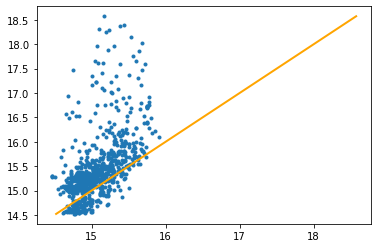

In [73]:
evalD('C', FModel)

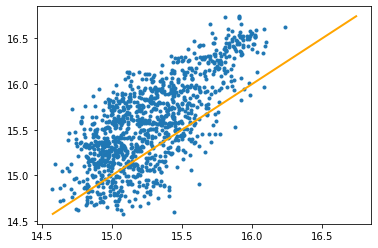

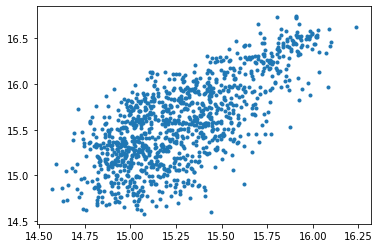

In [60]:
eval('D', Model_D)